<a href="https://colab.research.google.com/github/GarlandZhang/gans_in_action_notes/blob/master/adversarial_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install foolbox==2.4.0

     |████████████████████████████████| 1.9MB 5.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 460kB 40.7MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
  Created wheel for foolbox: filename=foolbox-2.4.0-cp36-none-any.whl size=1926223 sha256=ae605794a78eeb858fd43de603895adb6e332663cde62979e3706f8b56b5c860
  Stored in directory: /root/.cache/pip/wheels/ae/5a/11/a5b42761c70dd38c674d889f6ce7edc9867d0262f95de8712b
Successfully built foolbox


In [3]:
import numpy as np
from keras.applications.resnet50 import ResNet50
from foolbox.criteria import Misclassification, ConfidentMisclassification
from keras.preprocessing import image as img
from keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import foolbox
import pprint as pp
import keras
%matplotlib inline

In [5]:
# Let's get all the necessary files (two images to run data on and a simple CSV)
!wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
!wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0896.jpg
!wget https://raw.githubusercontent.com/GANs-in-Action/gans-in-action/master/chapter-10/initialization_vals_for_noise.csv

--2020-07-05 18:39:03--  https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GANs-in-Action/gans-in-action/Chapter-10/chapter-10/DSC_0897.jpg [following]
--2020-07-05 18:39:04--  https://raw.githubusercontent.com/GANs-in-Action/gans-in-action/Chapter-10/chapter-10/DSC_0897.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3028795 (2.9M) [image/jpeg]
Saving to: ‘DSC_0897.jpg’

DSC_0897.jpg        100%[===================>]   2.89M  17.4MB/s    in 0.2s    

2020-07-05 18:39:04 (17.4 MB/s) - ‘DSC_0897.jpg’ saved [3

In [4]:
def load_image(img_path):
  image = img.load_img(img_path, target_size=(224, 224))
  plt.imshow(image)
  x = img.img_to_array(image)
  return x

In [11]:
kmodel = ResNet50(weights='imagenet')

[('n03792972', 'mountain_tent', 0.6872753), ('n09399592', 'promontory', 0.073558465), ('n09468604', 'valley', 0.0717179), ('n04606251', 'wreck', 0.025214517), ('n09428293', 'seashore', 0.018810736), ('n01498041', 'stingray', 0.01020382), ('n04366367', 'suspension_bridge', 0.009102999), ('n02077923', 'sea_lion', 0.008893905), ('n09472597', 'volcano', 0.007715781), ('n09421951', 'sandbar', 0.005663447), ('n09193705', 'alp', 0.0052817506), ('n09256479', 'coral_reef', 0.005070698), ('n03042490', 'cliff_dwelling', 0.004853861), ('n03788365', 'mosquito_net', 0.0040941644), ('n03450230', 'gown', 0.003981229), ('n09246464', 'cliff', 0.0034005917), ('n04507155', 'umbrella', 0.0025982084), ('n09332890', 'lakeside', 0.0024168855), ('n02951358', 'canoe', 0.0020540704), ('n03160309', 'dam', 0.002033395)]
[('n09472597', 'volcano', 0.59141123), ('n04366367', 'suspension_bridge', 0.16848709), ('n09468604', 'valley', 0.08690409), ('n03792972', 'mountain_tent', 0.061730105), ('n09246464', 'cliff', 0.031

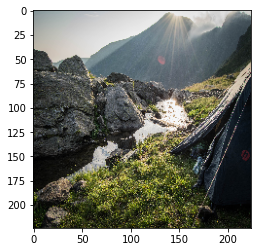

In [26]:
image = load_image('DSC_0897.jpg')
keras.backend.set_learning_phase(0)
preprocessing = (np.array([104, 116, 123]), 1)

fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)
to_classify = np.expand_dims(image, axis=0)

preds = kmodel.predict(to_classify)
print(decode_predictions(preds, top=20)[0])
label = np.argmax(preds)

image = image[:, :, ::-1]
attack = foolbox.attacks.FGSM(fmodel, threshold=.9, criterion=ConfidentMisclassification(.9))
adversarial = attack(np.expand_dims(image, axis=0), np.array([label]))

new_preds = kmodel.predict(adversarial)
print(decode_predictions(new_preds, top=20)[0])